In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# resizing, normalization and adaptive histogram equalization to images
import skimage.io as io
from skimage.transform import  rescale,resize
from skimage.util import img_as_uint,img_as_ubyte
from skimage.color import rgb2gray
from skimage import exposure
import os
import numpy as np
# source and destination dirs
classes = ["covid", "normal", "pneumonia"]
for class_name in classes:
    #class_name='covid'#'covid' or 'normal' or 'pneumonia'
    source_dir='drive/MyDrive/Covid19DataSet125/'+class_name
    destination_dir='dataset/'+class_name
    # list images list from source dir
    image_list=os.listdir(source_dir)# list of images
    # Normalization and adaptive histogram equalization to each single image
    for img_name in image_list:
        #print(img_name)
        img=io.imread(os.path.join(source_dir,img_name))
        img_gray = rgb2gray(img)
        img_resized = resize(img_gray, (512, 512))#convert image size to 512*512
        img_rescaled=(img_resized-np.min(img_resized))/(np.max(img_resized)-np.min(img_resized))#min-max normalization 
        img_enhanced=exposure.equalize_adapthist(img_rescaled)#adapt hist histogram eşitleme
        img_resized_8bit=img_as_ubyte(img_enhanced)
        io.imsave(os.path.join(destination_dir,img_name),img_resized_8bit)#save enhanced image to destination dir

In [ ]:
# feature extraction to create feature pool
import skimage.io as io
from skimage.transform import  rescale,resize
from skimage.util import img_as_uint,img_as_ubyte
from skimage.color import rgb2gray
from skimage import exposure
from sklearn.preprocessing import MinMaxScaler
import os
import numpy as np
from python_utils import converters
# source dir and output file name
# source and destination dirs
classes = ["covid", "normal", "pneumonia"]
for class_name in classes:
    #class_name='covid'#'covid' or 'normal' or 'pneumonia'
    source_dir='./dataset/'+class_name
    output_file_name=class_name
    # set labels
    if output_file_name=='covid':
        label=0
    elif output_file_name=='normal':
        label=1
    else:
        label=2
    # start
    image_list=os.listdir(source_dir)#list of images

    feature_pool=np.empty([1,252])#feature pool

    #Texture, Gray-Level Co-Occurrence Matrix (GLCM), Gray Level Difference Method (GLDM), Fast Fourier Transform (FFT) ve Wavelet tenikleri kullanılarak
    #her bir resim için 252 özellik çıkarma yapıltı
    for idx,img_name in enumerate(image_list):
        #print(idx,end=" - ")
        img=io.imread(os.path.join(source_dir,img_name))
        #Yığın normalleştirme ile yeniden ölçeklendirme - derin sinir ağlarındaki herhangi bir katmana 0’a ortalanmış ve 1 ile 0 arasında değerlere sahip veriler vermemizi sağlar.
        img_rescaled=(img-np.min(img))/(np.max(img)-np.min(img)) 
        
        texture_features=compute_14_features(img_rescaled)#texture features

        #2 boyutlu ayrık Fourier Dönüşümünü hesaplar. Bu fonksiyon, 2 boyutlu n-noktalı ayrık Fourier Dönüşümünü (DFT) verimli Hızlı Fourier Dönüşümü (FFT) algoritması [CT] ile hesaplar.
        fft_map = np.fft.fft2(img_rescaled)
        fft_map = np.fft.fftshift(fft_map)
        fft_map = np.abs(fft_map)
        YC=int(np.floor(fft_map.shape[1]/2)+1)
        fft_map=fft_map[:,YC:int(np.floor(3*YC/2))]
        fft_features=compute_14_features(fft_map)#FFT features
        
        #2 boyutlu ayrık dalgacık dönüşümü (wavelet)
        wavelet_coeffs = pywt.dwt2(img_rescaled,'sym4')
        cA1, (cH1, cV1, cD1) = wavelet_coeffs
        wavelet_coeffs = pywt.dwt2(cA1,'sym4')
        cA2, (cH2, cV2, cD2) = wavelet_coeffs#wavelet features
        wavelet_features=np.concatenate((compute_14_features(cA1), compute_14_features(cH1),compute_14_features(cV1),compute_14_features(cD1)
        ,compute_14_features(cA2), compute_14_features(cH2),compute_14_features(cV2),compute_14_features(cD2)), axis=0)
        
        #GLDM in four directions
        #GLDM, verilen görüntü için Gri seviyesi Farkı Yöntemi Olasılık Yoğunluk İşlevlerini hesaplar. 
        #Bu teknik genellikle bir dijital mamogramın istatistiksel doku özelliklerini çıkarmak için kullanılır.
        gLDM1,gLDM2,gLDM3,gLDM4=GLDM(img_rescaled,10)
        gldm_features=np.concatenate((compute_14_features(gLDM1), compute_14_features(gLDM2),
                                      compute_14_features(gLDM3),compute_14_features(gLDM4)), axis=0)
        #GLCM in four directions
        glcms =greycomatrix(img, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4])
        glcm_features=np.concatenate((compute_14_features(im2double(glcms[:, :, 0, 0])), 
                                      compute_14_features(im2double(glcms[:, :, 0, 1])),
                                      compute_14_features(im2double(im2double(glcms[:, :, 0, 2]))),
                                      compute_14_features(glcms[:, :, 0, 3])), axis=0)
        #(14 özellik Texture, 14 özellik FFT, 56 özellik GLCM, 56 özellik GLDM, 112 özellik Wavelet
        feature_vector=np.concatenate((texture_features,fft_features,wavelet_features,gldm_features,glcm_features), axis=0).reshape(1,252)#merge to create a feature vector of 252
        #Combine empty and example arrays
        feature_pool=np.concatenate((feature_pool,feature_vector), axis=0)


    feature_pool=np.delete(feature_pool, 0, 0)
    feature_pool=np.concatenate((feature_pool,label*np.ones(len(feature_pool)).reshape(len(feature_pool),1)), axis=1)#add label to the last column   
    sio.savemat(output_file_name+'.mat', {output_file_name: feature_pool})#save the created feature pool as a mat file   
    print(output_file_name+".mat file created")

covid.mat file created
normal.mat file created
pneumonia.mat file created


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 51        
Total params: 10,435
Trainable params: 10,435
Non-trainable params: 0
_________________________________________________________

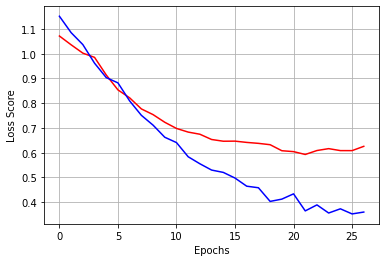

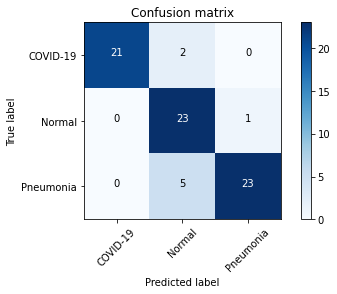

In [ ]:
from python_utils import converters
# source_dir
source_dir='./'
# load mat files
covid_features=sio.loadmat(os.path.join(source_dir,'covid.mat')) 
covid_features=covid_features['covid'] 

normal_features=sio.loadmat(os.path.join(source_dir,'normal.mat')) 
normal_features=normal_features['normal']  

pneumonia_features=sio.loadmat(os.path.join(source_dir,'pneumonia.mat')) 
pneumonia_features=pneumonia_features['pneumonia']    

# devide feature pool into inputs and target labels
X=np.concatenate((covid_features[:,:-1],normal_features[:,:-1],pneumonia_features[:,:-1]), axis=0)#inputs
y=np.concatenate((covid_features[:,-1],normal_features[:,-1],pneumonia_features[:,-1]), axis=0)#target labels

# normalization
min_max_scaler=MinMaxScaler()
X = min_max_scaler.fit_transform(X) 

# feature reduction (K-PCA)
transformer = KernelPCA(n_components=64, kernel='linear')
X = transformer.fit_transform(X)

# devide data into test,train, and validation sets
y = to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=1)
# build model
model = build_model(feature_size=X.shape[-1], n_classes=y.shape[-1])

show_model(model)
# train model
opt = tf.keras.optimizers.Adam(lr=0.001);
criterion = tf.keras.losses.categorical_crossentropy
model.compile(optimizer=opt, loss=criterion,metrics=[keras.metrics.categorical_accuracy])
model_early_stopping=EarlyStopping(monitor='val_loss', min_delta=.005, patience=5, verbose=1)# early stopping settings
model.fit(X_train, y_train,batch_size = 2,epochs=100, validation_data = (X_val, y_val),callbacks=[model_early_stopping])


fig = plt.figure()
plt.plot(model.history.history['val_loss'], 'r', model.history.history['loss'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Loss Score')
plt.grid(1)
plt.savefig('training_loss.jpg',dpi=300)
# evaluate model
Y_Score=model.predict(X_test)
y_pred = np.argmax(Y_Score, axis=1)
cm=confusion_matrix(np.argmax(y_test, axis=1),y_pred)
print(cm)

fig = plt.figure()
plot_confusion_matrix(cm,classes=['COVID-19','Normal','Pneumonia'])
plt.savefig('conf_matrix.jpg',dpi=300)

test_loss=model.evaluate(X_test,y_test,verbose=1)#evaluate model
print(test_loss)#print test loss and metrics information

In [ ]:
pip install imutils

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from imutils import paths
import numpy as np
import argparse
import imutils
import cv2
import os

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)                2064      
_________________________________________________________________
dropout_9 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 51        
Total params: 10,435
Trainable params: 10,435
Non-trainable params: 0
_______________________________________________________

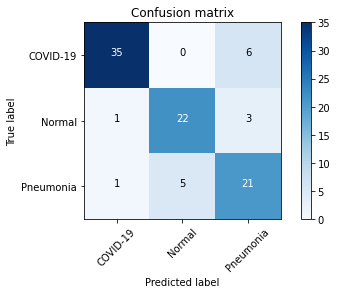

In [ ]:
#KNeighbors Classifier 
from python_utils import converters
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
# source_dir
source_dir='./'
# load mat files
covid_features=sio.loadmat(os.path.join(source_dir,'covid.mat')) 
covid_features=covid_features['covid'] 

normal_features=sio.loadmat(os.path.join(source_dir,'normal.mat')) 
normal_features=normal_features['normal']  

pneumonia_features=sio.loadmat(os.path.join(source_dir,'pneumonia.mat')) 
pneumonia_features=pneumonia_features['pneumonia']    

# devide feature pool into inputs and target labels
X=np.concatenate((covid_features[:,:-1],normal_features[:,:-1],pneumonia_features[:,:-1]), axis=0)#inputs
y=np.concatenate((covid_features[:,-1],normal_features[:,-1],pneumonia_features[:,-1]), axis=0)#target labels

# normalization
min_max_scaler=MinMaxScaler()
X = min_max_scaler.fit_transform(X) 

# feature reduction (K-PCA)
transformer = KernelPCA(n_components=64, kernel='linear')
X = transformer.fit_transform(X)

# devide data into test,train, and validation sets
y = to_categorical(y)

(trainRI, testRI, trainRL, testRL) = train_test_split(
	X, y, test_size=0.25, random_state=42)

(trainFeat, testFeat, trainLabels, testLabels) = train_test_split(
	X, y, test_size=0.25, random_state=42)

# build model
model = build_model(feature_size=X.shape[-1], n_classes=y.shape[-1])
show_model(model)
# train model

print("Evaluating KNN Accuracy...")
model = KNeighborsClassifier(n_neighbors=3)
model.fit(trainRI, trainRL)
acc = model.score(testRI, testRL)

acc = model.score(testFeat, testLabels)
print("KNN Accuracy: {:.2f}%".format(acc * 100))

predictions = model.predict(testRI)
print('KNN Accuracy: %.3f' % accuracy_score(testRL,predictions))


# evaluate model
Y_Score=model.predict(testRI)
y_pred = np.argmax(Y_Score, axis=1)
cm=confusion_matrix(np.argmax(testRL, axis=1),y_pred)
print(cm)

fig = plt.figure()
plot_confusion_matrix(cm,classes=['COVID-19','Normal','Pneumonia'])
plt.savefig('knn_conf_matrix.jpg',dpi=300)


In [ ]:
import cv2
import glob
import numpy as np
import scipy.io as sio
from scipy.stats import skew
from scipy.stats import kurtosis
import pywt
from skimage.feature import greycomatrix
import scipy.io as sio
import numpy as np
import seaborn as sn
import pandas as pd
from sklearn import preprocessing
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils import to_categorical
from sklearn import metrics
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from sklearn.decomposition import KernelPCA
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import itertools
import os
from sklearn.metrics import roc_curve, auc
kl = keras.layers
# im2double
def im2double(img):
    """ convert image to double format """
    min_val = np.min(img.ravel())
    max_val = np.max(img.ravel())
    out = (img.astype('float') - min_val) / (max_val - min_val)
    return out
# compute_14_features
def compute_14_features(region):
    """ Compute 14 features """
    temp_array=region.reshape(-1)
    all_pixels=temp_array[temp_array!=0]
#    Area
    Area = np.sum(all_pixels)
#    mean- aritmetik ortalama
    density = np.mean(all_pixels)
#   Std - standart sapma
    std_Density = np.std(all_pixels)
#   skewness- dağılımın asimetrisinin ölçüsü
    Skewness = skew(all_pixels)
#   kurtosis- bir dağılımın normal bir dağılıma göre ağır veya hafif bağlı olup olmadığının bir ölçüsüdür.
    Kurtosis = kurtosis(all_pixels)
#   Energy
    ENERGY =np.sum(np.square(all_pixels))
#   Entropy
    value,counts = np.unique(all_pixels, return_counts=True)
    p = counts / np.sum(counts)
    p =  p[p!=0]
    ENTROPY =-np.sum( p*np.log2(p));
#   Maximum
    MAX = np.max(all_pixels)
#   Mean Absolute Deviation
    sum_deviation= np.sum(np.abs(all_pixels-np.mean(all_pixels)))
    mean_absolute_deviation = sum_deviation/len(all_pixels)
#   Median
    MEDIAN = np.median(all_pixels)
#   Minimum
    MIN = np.min(all_pixels)
#   Range
    RANGE = np.max(all_pixels)-np.min(all_pixels)
#   Root Mean Square
    RMS = np.sqrt(np.mean(np.square(all_pixels))) 
#    Uniformity
    UNIFORMITY = np.sum(np.square(p))

    features = np.array([Area, density, std_Density,
        Skewness, Kurtosis,ENERGY, ENTROPY,
        MAX, mean_absolute_deviation, MEDIAN, MIN, RANGE, RMS, UNIFORMITY])
    return features
# GLDM
def GLDM(img, distance):
    """ GLDM in four directions """
    pro1=np.zeros(img.shape,dtype=np.float32)
    pro2=np.zeros(img.shape,dtype=np.float32)
    pro3=np.zeros(img.shape,dtype=np.float32)
    pro4=np.zeros(img.shape,dtype=np.float32)
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):

            if((j+distance)<img.shape[1]):
                pro1[i,j]=np.abs(img[i,j]-img[i,(j+distance)])
            if((i-distance)>0)&((j+distance)<img.shape[1]):
                pro2[i,j]=np.abs(img[i,j]-img[(i-distance),(j+distance)])
            if((i+distance)<img.shape[0]):
                pro3[i,j]=np.abs(img[i,j]-img[(i+distance),j])
            if((i-distance)>0)&((j-distance)>0):
                pro4[i,j]=np.abs(img[i,j]-img[(i-distance),(j-distance)])

    n=256;
    cnt, bin_edges=np.histogram(pro1[pro1!=0], bins=np.arange(n)/(n-1), density=False)
    Out1 = cnt.cumsum()
    cnt, bin_edges=np.histogram(pro2[pro2!=0], bins=np.arange(n)/(n-1), density=False)
    Out2 = cnt.cumsum()
    cnt, bin_edges=np.histogram(pro3[pro3!=0], bins=np.arange(n)/(n-1), density=False)
    Out3 = cnt.cumsum()
    cnt, bin_edges=np.histogram(pro4[pro4!=0], bins=np.arange(n)/(n-1), density=False)
    Out4 = cnt.cumsum()
    return Out1,Out2,Out3,Out4
#   show model
def show_model(model):
    plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
    return Image(filename='model.png')
# build model
def build_model(feature_size, n_classes):
    """ Build a small model for multi-label classification """
    inp = kl.Input((feature_size,))
    x = kl.Dense(128, activation='sigmoid')(inp)
    x=kl.Dropout(0.2)(x)
    x = kl.Dense(16, activation='sigmoid')(x)
    x=kl.Dropout(0.2)(x)
    out = kl.Dense(n_classes, activation='sigmoid')(x)
    model = keras.Model(inputs=inp, outputs=out)
    model.summary()
    return model
# plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')